## Importing Data

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

data_train, data_test = tf.keras.datasets.mnist.load_data()

(images_train, labels_train) = data_train
(images_test, labels_test) = data_test

## Check Data Type and Size

In [14]:
print(images_train.shape)
print(images_train[0].dtype)
print(labels_train.shape)
print(labels_train.dtype)

(60000, 28, 28)
uint8
(60000,)
uint8


## Functions that make feature

In [15]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

## Write TFRecord

In [16]:
def make_example(image, label):
    return Example(features=Features(feature={
        "image": _bytes_feature(image),
        "label": _int64_feature(label)
    }))

def write_tfrecord(images, labels, filename):
    writer = tf.io.TFRecordWriter(filename)
    labels = labels.astype(np.int64)
    for image, label in zip(images, labels):
        example_tmp = make_example(image.tobytes(), label)
        writer.write(example_tmp.SerializeToString())
    writer.close()

write_tfrecord(images_train, labels_train, "mnist_train.tfrecord")
write_tfrecord(images_test, labels_test, "mnist_test.tfrecord")

## Check if it is correct

In [17]:
raw_dataset = tf.data.TFRecordDataset("mnist_train.tfrecord")
for raw_record in raw_dataset.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\003\022\022\022~\210\257\032\246\377\367\177\000\000\000\000\000\000\000\000\000\000\000\000\036$^\232\252\375\375\375\375\375\341\254\375\362\303@\000\000\000\000\000\000\000\000\000\000\0001\356\375\375\375\375\375\375\375\375\373]RR8\'\000\000\000\000\000\000\000\000\000\000\000\000\022\333\375\375\3

## Load TFRecord

In [25]:
def _parse_tfrecord(tfrecord):
    feature_desc = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64)
    }
    x = tf.io.parse_single_example(tfrecord, feature_desc)
    image = tf.reshape(tf.io.decode_raw(x["image"], tf.uint8), [28, 28])
    label = x["label"]
    return image, label

def load_tfrecord_dataset(filename, batch_size=32, shuffle=True, buffer_size=10000, repeat=1):
    mnist_dataset = tf.data.TFRecordDataset(filename)
    mnist_dataset = mnist_dataset.repeat(repeat)
    if shuffle:
        mnist_dataset = mnist_dataset.shuffle(buffer_size=buffer_size)
    parsed_mnist = mnist_dataset.map(_parse_tfrecord, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    parsed_mnist = parsed_mnist.batch(batch_size)
    return parsed_mnist.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [26]:
parsed_mnist = load_tfrecord_dataset("mnist_train.tfrecord")

## Show Parsed MNIST Data

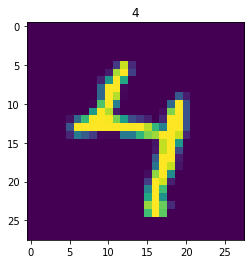

In [29]:
for img, label in parsed_mnist.take(1):
    plt.imshow(img[0])
    plt.title(label[0].numpy())